# IMPORT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# path dataset
file_path = "/content/drive/MyDrive/Progetti data science/Progetto Python/Classificazione/songs_spotify.csv"

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter


#import optuna
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, auc, confusion_matrix, f1_score, plot_roc_curve

from sklearn import set_config

# Render modello
from sklearn.tree import plot_tree

# ETL

In [3]:
# import file and watching head
df = pd.read_csv(file_path, low_memory=False)

df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


<h3> Eliminiamo i dati categorici, tranne la colonna del genere musicale <h3>

In [4]:
df = df.drop(columns = ["type", "id", "uri", "track_href", "analysis_url", "song_name","Unnamed: 0", "title" ])

# ADDESTRAMENTO MODELLI

## Funzioni e parametri comuni a tutti i modelli

<h3> Seed che sarà usato in tutti gli algoritmi <h3>

In [5]:
seed = 42

<h3> Funzione di supporto per plottare l'andamento delle prestazioni in base a 2 dei parametri utilizzati nella grid search <h3>

In [6]:
# tree_table -> dataset contenente i valori da plottare
# name_param_1 -> nome del primo parametro 
# name_param_2 -> nome del secondo parametro 
# metrica -> nome della metrica utilizzata


def plot_grid_search_line(tree_table, nome_param_1, nome_param_2, metrica = 'accuracy'):

    # creiamo due pivot_table, uno per i dati della media ed uno per i dati della deviazione standars
    df_media = tree_table.pivot_table(values=metrica, index=nome_param_1, columns=nome_param_2)
    df_std = tree_table.pivot_table(values='Std_deviation', index=nome_param_1, columns=nome_param_2)

    # Creiamo un plot con due figure
    _, (ax1, ax2) = plt.subplots(1,2, figsize = (18, 8))
    
    # per ogni valore assunto dal parametro2 creiamo una linea 
    for valore in sorted(list(set(tree_table[nome_param_2])), reverse=True):
      ax1.plot(df_media[valore], label=f'{nome_param_2}: {valore}', linestyle = '--', marker = 'o')

    ax1.set_title(f'{metrica} media \n per iterazione', fontsize=18, fontweight='bold')
    ax1.set_xlabel(nome_param_1, fontsize=16)
    ax1.set_ylabel(f'Media della {metrica}', fontsize=16)
    ax1.legend(loc="best", fontsize=15)
    ax1.grid('on')

    # per ogni valore assunto dal parametro2 creiamo una linea 
    for valore in sorted(list(set(tree_table[nome_param_2])), reverse=True):
      ax2.plot(df_std[valore], label=f'{nome_param_2}: {valore}', linestyle = '--', marker = 'o')

    ax2.set_title(f'Varianza della {metrica} \n per iterazione', fontsize=18, fontweight='bold')
    ax2.set_xlabel(nome_param_1, fontsize=16)
    ax2.set_ylabel(f'Varianza della {metrica}', fontsize=16)
    ax2.legend(loc="best", fontsize=15)
    ax2.grid('on')


<h3> Funzione di supporto per plottare una heatmap delle prestazioni in base a 2 o 3 dei parametri utilizzati nella grid search <h3>

In [7]:
# tree_table -> dataset contenente i valori da plottare
# name_param_1 -> nome del primo parametro 
# name_param_2 -> nome del secondo parametro 
# nome_param_3 -> nome del terzo parametro 

def plot_grid_search_heatmap(tree_table, nome_param_1, nome_param_2, nome_param_3, metrica='accuracy', size=(20, 6)):

      # estraggo il valore massimo e minimo per la media (servirà per la legenda dell'heatmap)
      min_of_mean = tree_table[metrica].min()
      max_of_mean = tree_table[metrica].max()
      #estraggo il valore massimo e minimo per la deviazione standard (servirà per la legenda dell'heatmap)
      min_of_std = tree_table['Std_deviation'].min()
      max_of_std = tree_table['Std_deviation'].max()
      # estraggo i valori categorici unici nella colonna
      unique_values = sorted(list(set(list(tree_table[nome_param_3]))))

      # creo un subploat con due colonne ed u numero di righe pari al numero di valori unici nel terzo parametro
      fig, axs = plt.subplots(len(unique_values), 2, figsize=size)
      fig.tight_layout(pad=8.0)
      axs = axs.ravel()

      # iteriamo da 0 al doppio del numero di valori unici del parametro tre, con passo pari a due 
      # (in questo modo posso riferirmi al grafico axs[i] per la media ed il grafico axs[i+1] per la varianza) 
      for i in range(0, (len(unique_values))*2, 2):
        # estraiamo i valori nel dataframe relativi all'i_esimo valore unico del parametro_3
        values_for_category = tree_table[tree_table[nome_param_3] == unique_values[int(i/2)]]



        # creo la tabella pivot per l'accuracy e la plotto come heatmap
        acc_heatmap = values_for_category.pivot_table(values=metrica, index=nome_param_1, columns=nome_param_2)
        sns.heatmap(acc_heatmap, annot=True, fmt='.4f', linewidth=.5, ax=axs[i], vmin=min_of_mean, vmax=max_of_mean, cmap = "flare")
        axs[i].set_title(f'{metrica} con {nome_param_3}: \n {unique_values[int(i/2)]}', fontsize=18, fontweight='bold')
        axs[i].set_xlabel(nome_param_2, fontsize=12, fontweight='bold')
        axs[i].set_ylabel(nome_param_1, fontsize=12, fontweight='bold')
        # scorriamo la tabella pivot dell'Accuracy per cercare la posizione del massimo valore
        max_value_acc = 0
        max_col_acc = 0
        max_index_acc = 0
        current_index_acc = 0

        for idx, row in acc_heatmap.iterrows():
          if np.max(row) > max_value_acc:
              max_value_acc = np.max(row) 
              max_col_acc = np.argmax(row)
              max_index_acc = current_index_acc
          current_index_acc += 1 
        
        # plot del rettangolo sulla posizione del massimo valore
        axs[i].add_patch(plt.Rectangle((max_col_acc, max_index_acc), 1, 1, fc='none', ec='black', lw=3, clip_on=False))



        # creo la tabella pivot per la deviazione standard e la plotto come heatmap
        std_heatmap = values_for_category.pivot_table(values='Std_deviation', index=nome_param_1, columns=nome_param_2)
        sns.heatmap(std_heatmap, annot=True, fmt='.4f', linewidth=.5, ax=axs[i+1], vmin=min_of_std, vmax=max_of_std, cmap = "crest")
        axs[i+1].set_title(f'Deviazione standard con {nome_param_3}: \n {unique_values[int(i/2)]}', fontsize=18, fontweight='bold')
        axs[i+1].set_xlabel(nome_param_2, fontsize=12, fontweight='bold')
        axs[i+1].set_ylabel(nome_param_1, fontsize=12, fontweight='bold')
        # scorriamo la tabella pivot della deviazione standard per cercare la posizione del massimo valore
        min_value_std = 100
        min_col_std = 0
        min_index_std = 0
        current_index_std = 0

        for idx, row in std_heatmap.iterrows():
          if np.min(row) < min_value_std:
              min_value_std = np.min(row) 
              min_col_std = np.argmin(row)
              min_index_std = current_index_std
          current_index_std += 1

        # plot del rettangolo sulla posizione del massimo valore
        axs[i+1].add_patch(plt.Rectangle((min_col_std, min_index_std), 1, 1, fc='none', ec='black', lw=3, clip_on=False))


<h3> Split stratificato in train (85%) e test (15%) <h3>

In [8]:
x = df.drop(['genre'], axis=1)
y = df['genre']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=seed, stratify=y)


print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

x_train: (35959, 13)
x_test: (6346, 13)
y_train: (35959,)
y_test: (6346,)


<h3> Parte della pipeline che sarà uguale in tutti gli algoritmi di classificazione (cioè la parte di scaling) <h3>

In [9]:
# contiene la lista delle colonne da normalizzare (tutte tranne mode che vale o 0 o 1 quindi non ha senso normalizzarlo)
to_normalize = list(x.drop(['mode'], axis=1).columns)

# creiamo un normalizer che è una pipeline costituita solo dallo standard scaler
normalizer = make_pipeline(
    StandardScaler()
)

# creiamo una trasformazione che applica la pipeline di normalizzazione solo alla lista di colonne che ci interessano 
# il "passthrough" dice che le colonne nella lista "to_normalize" vengono normalizzate, 
# le altre invece vengono lasciate invariate (altrimenti senza "passthrough" verrebbero eliminate)
preprocessor = make_column_transformer(
    (normalizer, to_normalize),
    remainder='passthrough'
)

## CLASSIFICATION TREE

<h3> Creazione della pipeline e scelta dei parametri per la GridSearch <h3>

In [ ]:
tree_pipe = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['tree', DecisionTreeClassifier()]],
    verbose = True)

tree_max_depth = [i for i in range(8, 20, 2)]
tree_min_samples_split = [i for i in range(10, 65, 10)]
tree_criterion = ['entropy', 'gini']

param_grid = {
    'tree__max_depth': tree_max_depth,
    'tree__min_samples_split': tree_min_samples_split,
    'tree__random_state': [seed],
    'tree__criterion': tree_criterion
    }


set_config(display='diagram')
display(tree_pipe)
set_config(display='text')

Pipeline(steps=[['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])],
                ['tree', DecisionTreeClassifier()]],
         verbose=True)

### Valutazione parametri

<h3> Applichiamo sul dataset di train la GridSearch facendo una Cross Validation con K = 5 <h3>

In [ ]:
scoring='accuracy'

tree_model = GridSearchCV(tree_pipe,
                    param_grid=param_grid,
                    cv=3,
                    n_jobs=-1,
                    verbose=80,
                    scoring=scoring
                    )


# alleniamo il modello e valutiamo i risultati della Cross Validation eseguita dalla GridSearch 
tree_pipe_grid_results = tree_model.fit(x_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .............. (step 2 of 2) Processing tree, total=   0.5s


<h3> Prime 10 iterazioni con Accuracy più alta <h3>

In [ ]:
tree_table = pd.concat([pd.DataFrame(tree_pipe_grid_results.cv_results_["params"]),
                        pd.DataFrame(tree_pipe_grid_results.cv_results_["mean_test_score"], columns=[scoring]),
                        pd.DataFrame(tree_pipe_grid_results.cv_results_["std_test_score"], columns = ['Std_deviation'])],axis=1).\
                        sort_values([scoring], ascending=False)
tree_table.head(10)

,tree__criterion,tree__max_depth,tree__min_samples_split,tree__random_state,accuracy,Std_deviation
51,gini,12,40,42,0.622236,0.002019
50,gini,12,30,42,0.622153,0.001423
9,entropy,10,40,42,0.621652,0.001531
10,entropy,10,50,42,0.621235,0.001521
52,gini,12,50,42,0.621180,0.000899
8,entropy,10,30,42,0.621152,0.001202
15,entropy,12,40,42,0.621068,0.001349
16,entropy,12,50,42,0.620985,0.001072
17,entropy,12,60,42,0.620902,0.000551
49,gini,12,20,42,0.620651,0.000273


<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth <h3>

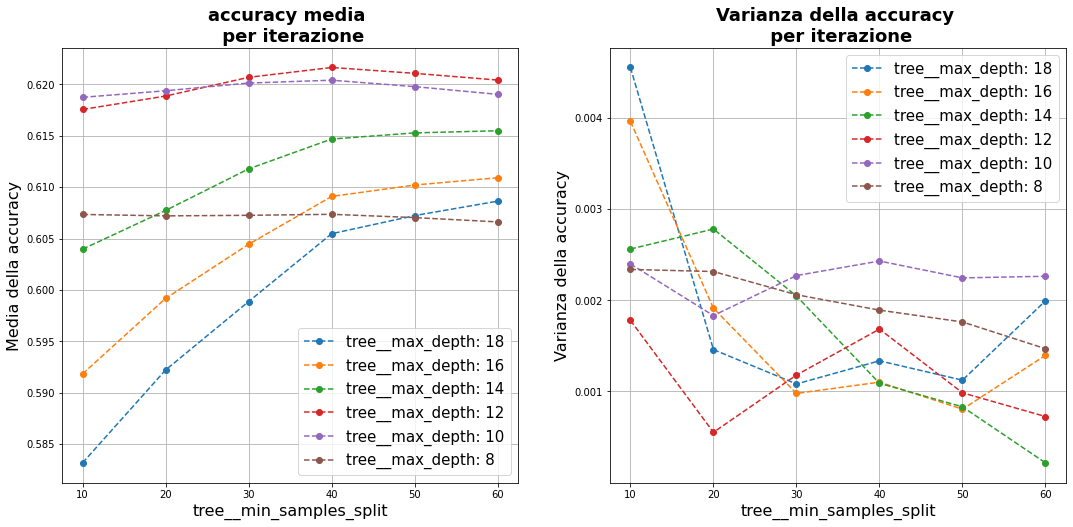

In [ ]:
plot_grid_search_line(tree_table, 'tree__min_samples_split', 'tree__max_depth')
#tree_pipe_grid_results.best_estimator_

<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth per ogni valore di tree_criterion <h3>

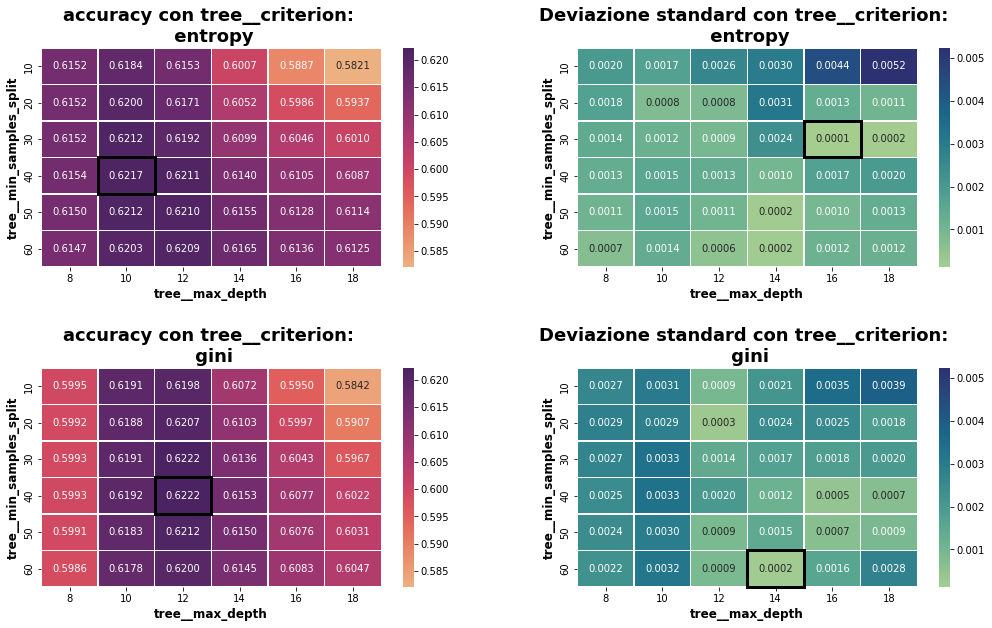

In [ ]:
plot_grid_search_heatmap(tree_table, 'tree__min_samples_split', 'tree__max_depth', 'tree__criterion', size=(16, 10), metrica=scoring)

<h3> Miglior Modello <h3>

In [ ]:
tree_pipe_grid_results.best_estimator_['tree']

DecisionTreeClassifier(max_depth=12, min_samples_split=40, random_state=42)

### Accuratezza sul Test Set

<h3> Alleniamo un nuovo modello con i parametri ottimi e testiamolo <h3>

In [10]:
tree_model_ottimo = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['tree', DecisionTreeClassifier(random_state=42, criterion = 'entropy', max_depth=10, min_samples_split=30)]],
    verbose = True)


tree_model_ottimo = tree_model_ottimo.fit(x_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] .............. (step 2 of 2) Processing tree, total=   3.0s


In [11]:
classes = list(tree_model_ottimo.classes_)
features = list(x.columns)

In [12]:
# calcoliamo le predizione del modello sul test_set
tree_predictions_test = tree_model_ottimo.predict(x_test)

# calcoliamo le predizione del modello sul train_set
tree_predictions_train = tree_model_ottimo.predict(x_train)

# stampiamo un resoconto della predizione
print(classification_report(tree_predictions_test, y_test))

print(f'f1_score_train: {f1_score(y_train,tree_predictions_train,average="micro")}')
print(f'f1_score_test: {f1_score(y_test,tree_predictions_test,average="micro")}')

                 precision    recall  f1-score   support

      Dark Trap       0.41      0.50      0.45       563
            Emo       0.57      0.57      0.57       253
         Hiphop       0.44      0.45      0.44       437
            Pop       0.01      0.12      0.03         8
            Rap       0.29      0.87      0.44        93
            RnB       0.31      0.30      0.31       331
     Trap Metal       0.20      0.35      0.26       169
Underground Rap       0.64      0.42      0.51      1351
            dnb       0.96      0.97      0.96       440
      hardstyle       0.86      0.77      0.81       496
      psytrance       0.87      0.90      0.89       426
      techhouse       0.87      0.85      0.86       461
         techno       0.82      0.84      0.83       432
         trance       0.81      0.76      0.78       483
           trap       0.70      0.78      0.74       403

       accuracy                           0.64      6346
      macro avg       0.58   

<h3> Stampiamo la matrice di confusione in forma grafica <h3>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text major ticklabel objects>)

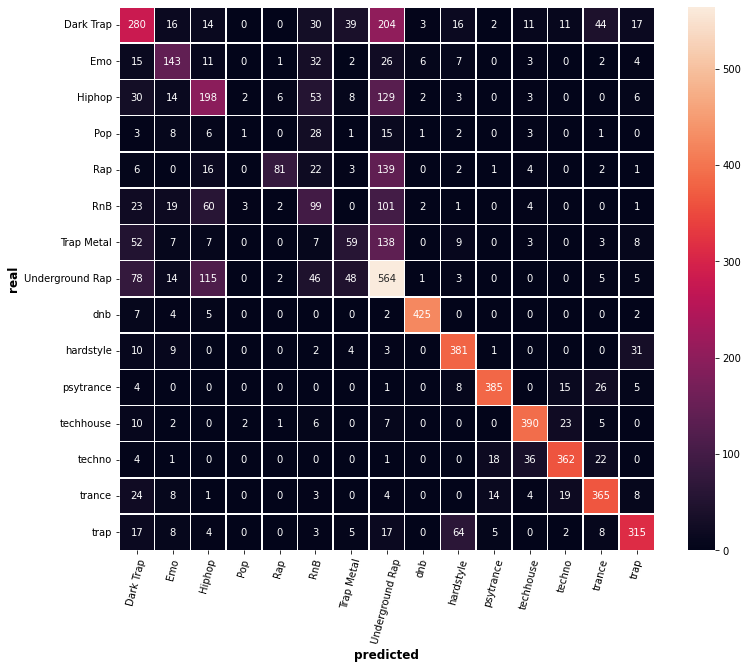

In [13]:
tree_matrix = confusion_matrix(y_test, tree_predictions_test, labels=classes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(tree_matrix, ax=ax, annot=True, fmt='d', linewidths=0.5)
ax.set_xticklabels(classes);
ax.set_yticklabels(classes);
ax.set_xlabel('predicted', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
ax.set_ylabel('real', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)

<h3> Visualizziamo il modello <h3>

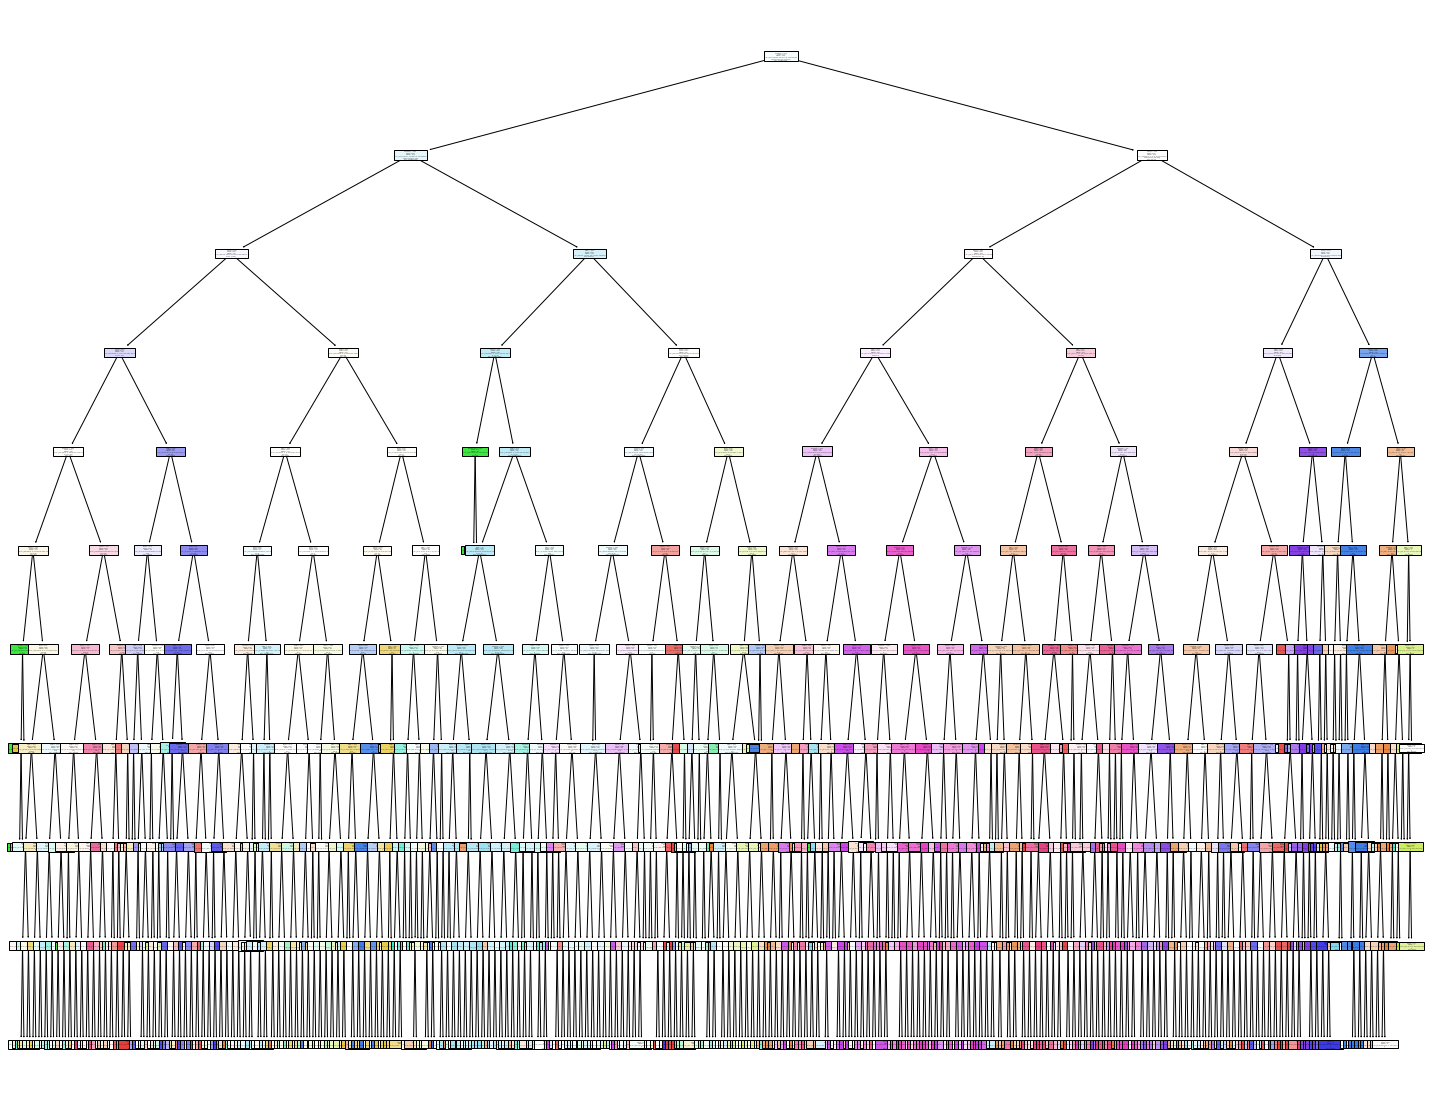

In [14]:
fig = plt.figure(figsize=(25,20))
plot = plot_tree(tree_model_ottimo['tree'], 
                   feature_names=features,  
                   class_names=classes,
                   filled=True)

fig.savefig("/content/drive/MyDrive/Robe/Progetto Python/Albero_ottimo.png")


## RANDOM FOREST 

<h3> Creazione della pipeline e scelta dei parametri per la GridSearch <h3>

In [ ]:
RDF_pipe = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['RDF', RandomForestClassifier()]],
    verbose = True)


RDF__max_depth = [i for i in range(10, 19, 4)]
RDF__min_samples_split = [i for i in range(5, 36, 10)]
RDF__n_estimators = [150, 250, 400]
RDF__criterion = ['entropy']


param_grid = {
    'RDF__max_depth': RDF__max_depth,
    'RDF__min_samples_split': RDF__min_samples_split,
    'RDF__random_state': [seed],
    'RDF__n_estimators': RDF__n_estimators,
    'RDF__criterion': RDF__criterion
    }


set_config(display='diagram')
display(RDF_pipe)
set_config(display='text')

Pipeline(steps=[['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])],
                ['RDF', RandomForestClassifier()]],
         verbose=True)

### Valutazione parametri

<h3> Applichiamo sul dataset di train la GridSearch facendo una Cross Validation con K = 3 <h3>

In [ ]:
scoring = 'accuracy'

RDF_model = GridSearchCV(RDF_pipe,
                    param_grid=param_grid,
                    cv=3,
                    n_jobs=-1,
                    verbose=3,
                    scoring = scoring
                    )


# alleniamo il modello e valutiamo i risultati della Cross Validation eseguita dalla GridSearch 
RDF_pipe_grid_results = RDF_model.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing RDF, total= 1.7min


<h3> Prime 10 iterazioni con Accuracy più alta <h3>

In [ ]:
RDF_table = pd.concat([pd.DataFrame(RDF_pipe_grid_results.cv_results_["params"]),
                       pd.DataFrame(RDF_pipe_grid_results.cv_results_["mean_test_score"], columns=[scoring]), 
                       pd.DataFrame(RDF_pipe_grid_results.cv_results_["std_test_score"], columns = ['Std_deviation'])],axis=1).\
                       sort_values([scoring], ascending=False)
RDF_table.head(10)

,RDF__criterion,RDF__max_depth,RDF__min_samples_split,RDF__n_estimators,RDF__random_state,accuracy,Std_deviation
17,entropy,14,15,400,42,0.676326,0.002796
16,entropy,14,15,250,42,0.676242,0.003765
20,entropy,14,25,400,42,0.675491,0.001444
19,entropy,14,25,250,42,0.675269,0.002255
18,entropy,14,25,150,42,0.674880,0.003524
23,entropy,14,35,400,42,0.674602,0.001915
30,entropy,18,25,150,42,0.674490,0.001751
31,entropy,18,25,250,42,0.674379,0.001961
15,entropy,14,15,150,42,0.674379,0.003982
29,entropy,18,15,400,42,0.674323,0.003104


<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth <h3>

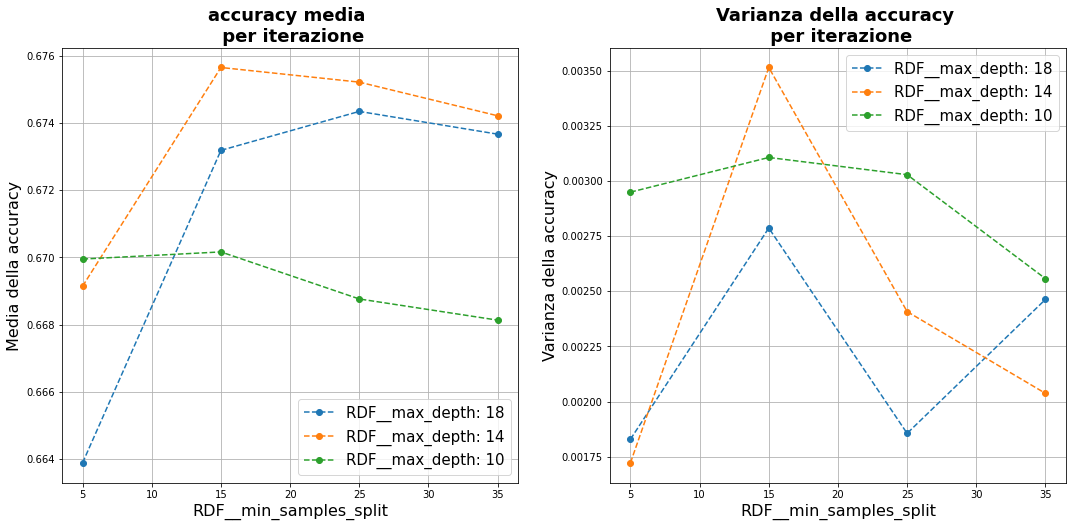

In [ ]:
plot_grid_search_line(RDF_table, 'RDF__min_samples_split', 'RDF__max_depth')
#RDF_pipe_grid_results.best_estimator_

<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth per ogni valore di n_estimators <h3>

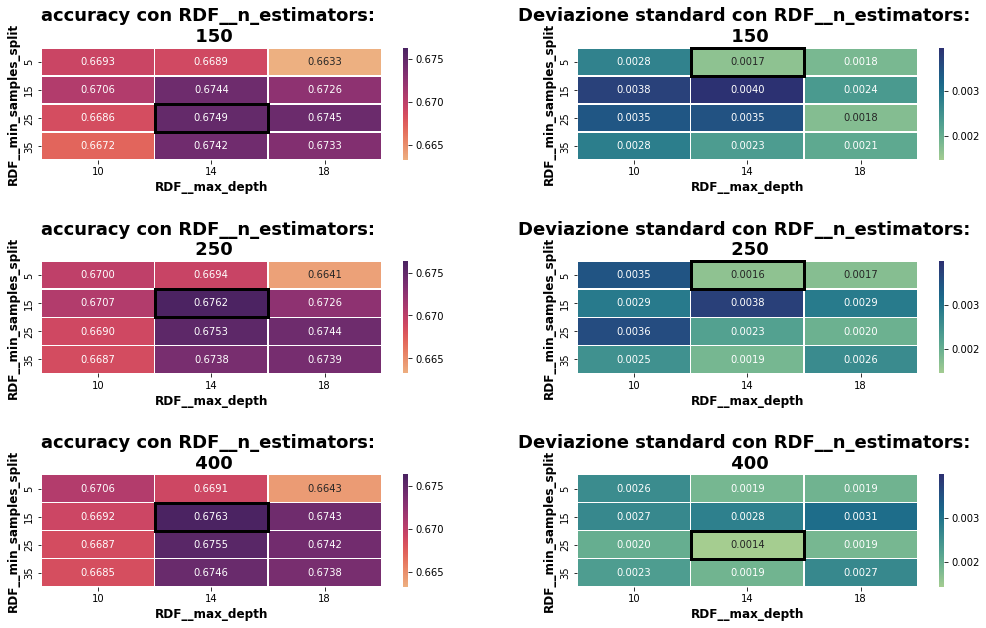

In [ ]:
plot_grid_search_heatmap(RDF_table, 'RDF__min_samples_split', 'RDF__max_depth', 'RDF__n_estimators', size=(16, 10), metrica = scoring)

<h3> Miglior Modello <h3>

In [ ]:
RDF_pipe_grid_results.best_estimator_['RDF']

RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_split=15,
                       n_estimators=400, random_state=42)

### Accuratezza sul Test Set

<h3> Alleniamo un nuovo modello con i parametri ottimi e testiamolo <h3>

In [15]:
RDF_model_ottimo = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['RDF', RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_split=15, n_estimators=400, random_state=42)]],
    verbose = True)


RDF_model_ottimo.fit(x_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing RDF, total= 1.7min


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])),
                ['RDF',
                 RandomForestClassifier(criterion='entropy', max_depth=14,
         

In [16]:
classes = list(RDF_model_ottimo.classes_)
features = list(x.columns)

In [17]:
# calcoliamo le predizione del modello sul test_set
RDF_predictions_test = RDF_model_ottimo.predict(x_test)
# calcoliamo le predizione del modello sul train_set
RDF_predictions_train = RDF_model_ottimo.predict(x_train)


# stampiamo un resoconto della predizione
print(classification_report(RDF_predictions_test, y_test))
print(f'f1_score_train: {f1_score(y_train,RDF_predictions_train,average="weighted")}')
print(f'f1_score_test: {f1_score(y_test,RDF_predictions_test,average="weighted")}')

                 precision    recall  f1-score   support

      Dark Trap       0.46      0.54      0.50       589
            Emo       0.66      0.70      0.68       237
         Hiphop       0.46      0.50      0.48       413
            Pop       0.03      1.00      0.06         2
            Rap       0.31      0.84      0.45       102
            RnB       0.34      0.44      0.39       244
     Trap Metal       0.22      0.45      0.30       146
Underground Rap       0.66      0.42      0.51      1391
            dnb       0.98      0.96      0.97       458
      hardstyle       0.93      0.83      0.88       492
      psytrance       0.91      0.92      0.92       443
      techhouse       0.92      0.88      0.90       466
         techno       0.88      0.88      0.88       446
         trance       0.88      0.83      0.85       474
           trap       0.85      0.86      0.85       443

       accuracy                           0.69      6346
      macro avg       0.63   

<h3> Stampiamo la matrice di confusione in forma grafica <h3>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text major ticklabel objects>)

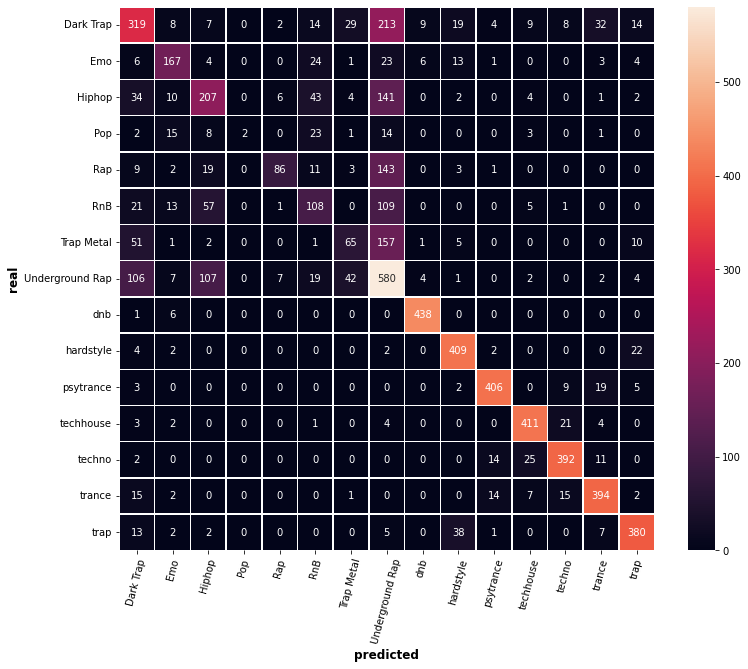

In [18]:
DF_matrix = confusion_matrix(y_test, RDF_predictions_test, labels=classes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(DF_matrix, ax=ax, annot=True, fmt='d', linewidths=0.5)
ax.set_xticklabels(classes);
ax.set_yticklabels(classes);
ax.set_xlabel('predicted', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
ax.set_ylabel('real', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)

## KNN

<h3> Creazione della pipeline e scelta dei parametri per la GridSearch <h3>

In [ ]:
knn_pipe = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['knn', KNeighborsClassifier()]],
    verbose = True)

knn_max_depth = [i for i in range(3, 28, 2)]
knn_p = [1,2]
knn_algorithm = ['ball_tree', 'kd_tree', 'brute']

param_grid = {
    'knn__n_neighbors': knn_max_depth,
    'knn__algorithm': knn_algorithm,
    'knn__p': knn_p
    }


set_config(display='diagram')
display(knn_pipe)
set_config(display='text')

Pipeline(steps=[['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])],
                ['knn', KNeighborsClassifier()]],
         verbose=True)

### Valutazione parametri

<h3> Applichiamo sul dataset di train la GridSearch facendo una Cross Validation con K = 5 <h3>

In [ ]:
scoring='accuracy'

knn_model = GridSearchCV(knn_pipe,
                    param_grid=param_grid,
                    cv=3,
                    n_jobs=-1,
                    verbose=80,
                    scoring=scoring
                    )


# alleniamo il modello e valutiamo i risultati della Cross Validation eseguita dalla GridSearch 
knn_pipe_grid_results = knn_model.fit(x_train, y_train)

Fitting 3 folds for each of 78 candidates, totalling 234 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.1s


<h3> Prime 10 iterazioni con Accuracy più alta <h3>

In [ ]:
knn_table = pd.concat([pd.DataFrame(knn_pipe_grid_results.cv_results_["params"]),
                        pd.DataFrame(knn_pipe_grid_results.cv_results_["mean_test_score"], columns=[scoring]),
                        pd.DataFrame(knn_pipe_grid_results.cv_results_["std_test_score"], columns = ['Std_deviation'])],axis=1).\
                        sort_values([scoring], ascending=False)
knn_table.head(10)

,knn__algorithm,knn__n_neighbors,knn__p,accuracy,Std_deviation
48,kd_tree,25,1,0.602686,0.002972
74,brute,25,1,0.602575,0.003492
50,kd_tree,27,1,0.602575,0.003919
24,ball_tree,27,1,0.602492,0.003887
76,brute,27,1,0.602436,0.003824
22,ball_tree,25,1,0.602408,0.003227
46,kd_tree,23,1,0.602130,0.002970
72,brute,23,1,0.602019,0.003056
20,ball_tree,23,1,0.601769,0.002989
70,brute,21,1,0.601018,0.002096


<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a knn__n_neighbors e knn__algorithm <h3>

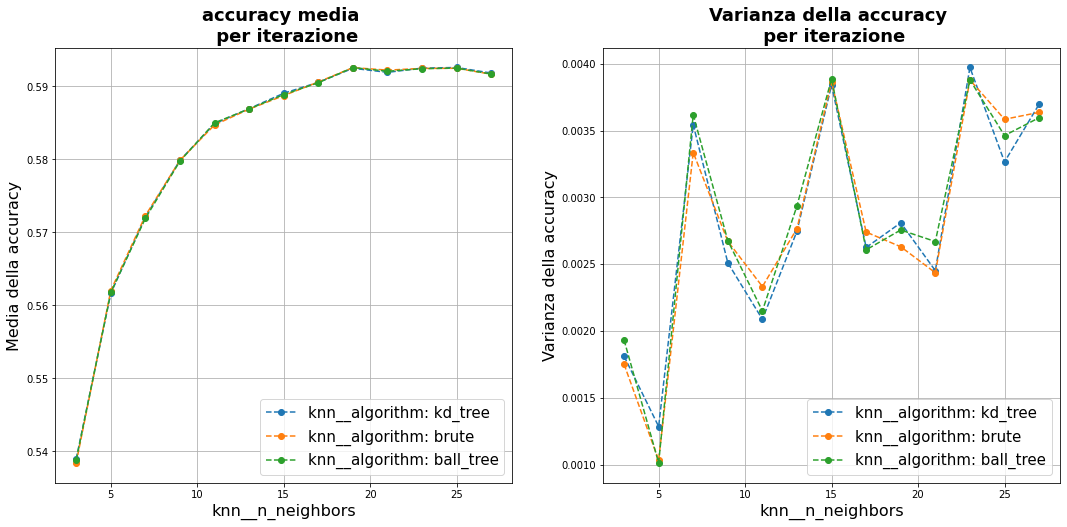

In [ ]:
plot_grid_search_line(knn_table, 'knn__n_neighbors', 'knn__algorithm')
#knn_pipe_grid_results.best_estimator_

<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a knn__n_neighbors e knn__algorithm per ogni valore di knn__p <h3>

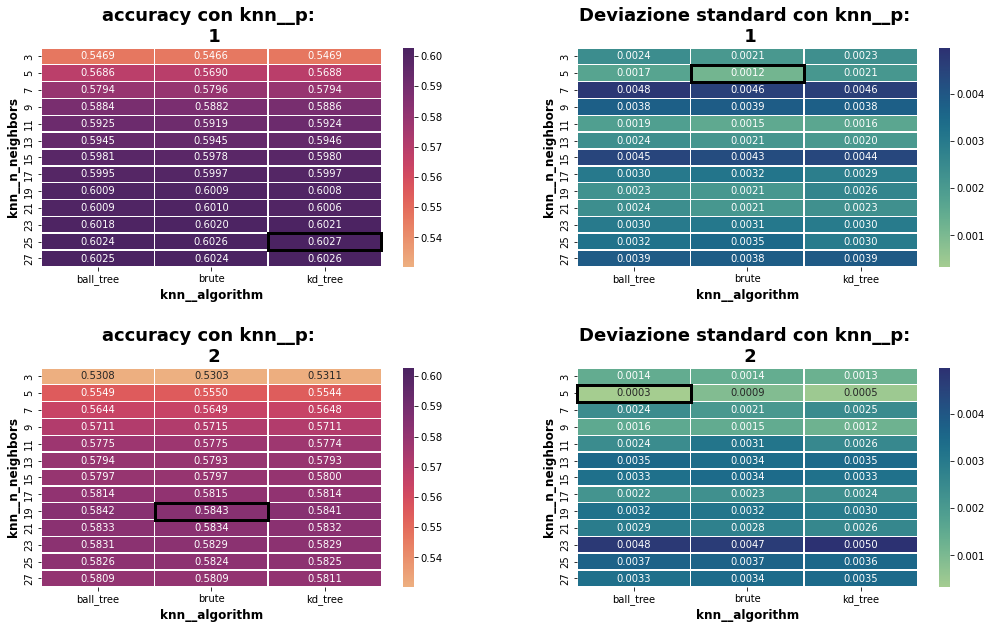

In [ ]:
plot_grid_search_heatmap(knn_table, 'knn__n_neighbors', 'knn__algorithm', 'knn__p', size=(16, 10), metrica=scoring)

<h3> Miglior Modello <h3>

In [ ]:
knn_pipe_grid_results.best_estimator_['knn']

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=25, p=1)

### Accuratezza sul Test Set

<h3> Alleniamo un nuovo modello con i parametri ottimi e testiamolo <h3>

In [19]:
knn_model_ottimo = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['knn', KNeighborsClassifier(algorithm='brute', n_neighbors=17, p=1)]],
    verbose = True)


knn_model_ottimo = knn_model_ottimo.fit(x_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s


In [20]:
classes = list(knn_model_ottimo.classes_)
features = list(x.columns)

In [21]:
# calcoliamo le predizione del modello sul test_set
knn_predictions_test = knn_model_ottimo.predict(x_test)
# calcoliamo le predizione del modello sul train_set
knn_predictions_train = knn_model_ottimo.predict(x_train)


# stampiamo un resoconto della predizione
print(classification_report(knn_predictions_test, y_test))

print(f'f1_score_train: {f1_score(y_train,knn_predictions_train,average="micro")}')
print(f'f1_score_test: {f1_score(y_test,knn_predictions_test,average="micro")}')

                 precision    recall  f1-score   support

      Dark Trap       0.40      0.48      0.44       567
            Emo       0.55      0.54      0.55       257
         Hiphop       0.40      0.45      0.43       405
            Pop       0.06      0.22      0.09        18
            Rap       0.27      0.52      0.35       143
            RnB       0.24      0.37      0.29       201
     Trap Metal       0.14      0.37      0.21       115
Underground Rap       0.61      0.41      0.49      1287
            dnb       0.93      0.88      0.91       472
      hardstyle       0.88      0.68      0.76       574
      psytrance       0.88      0.78      0.83       503
      techhouse       0.84      0.79      0.81       470
         techno       0.85      0.80      0.83       474
         trance       0.66      0.71      0.68       413
           trap       0.74      0.74      0.74       447

       accuracy                           0.61      6346
      macro avg       0.56   

<h3> Stampiamo la matrice di confusione in forma grafica <h3>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text major ticklabel objects>)

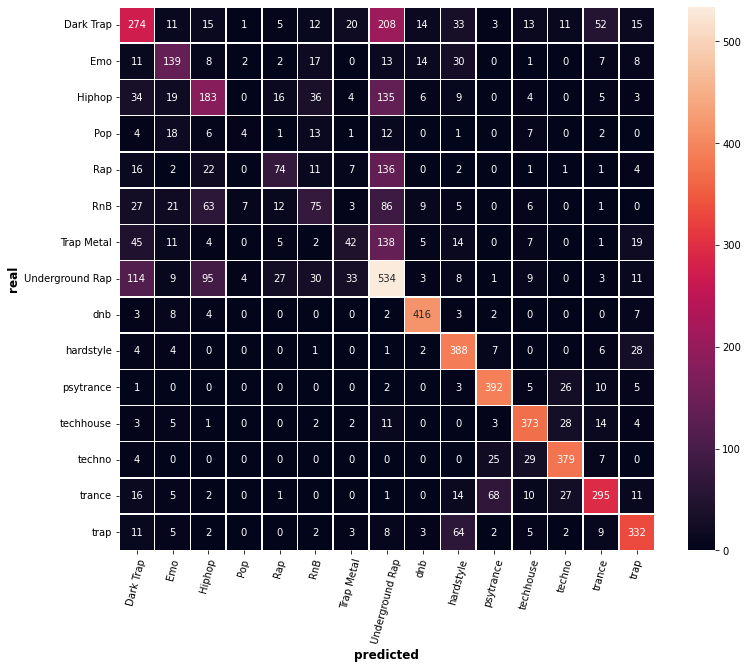

In [22]:
knn_matrix = confusion_matrix(y_test, knn_predictions_test, labels=classes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(knn_matrix, ax=ax, annot=True, fmt='d', linewidths=0.5)
ax.set_xticklabels(classes);
ax.set_yticklabels(classes);
ax.set_xlabel('predicted', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
ax.set_ylabel('real', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)

## Extra Trees 

<h3> Creazione della pipeline e scelta dei parametri per la GridSearch <h3>

In [ ]:
XT_pipe = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['XT', ExtraTreesClassifier()]
    ],
    verbose = True)


XT__max_depth = [i for i in range(20, 51, 10)]
XT__min_samples_split = [i for i in range(5, 25, 8)]
XT__n_estimators = [400, 600, 800]
XT__min_impurity_decrease = [1.0e-07, 1.0e-06, 1.0e-05]
XT__criterion = ['entropy']


param_grid = {
    'XT__max_depth': XT__max_depth,
    'XT__min_samples_split': XT__min_samples_split,
    'XT__random_state': [seed],
    'XT__n_estimators': XT__n_estimators,
    'XT__criterion': XT__criterion,
    'XT__min_impurity_decrease': XT__min_impurity_decrease
    }


set_config(display='diagram')
display(XT_pipe)
set_config(display='text')

Pipeline(steps=[['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])],
                ['XT', ExtraTreesClassifier()]],
         verbose=True)

### Valutazione parametri

<h3> Applichiamo sul dataset di train la GridSearch facendo una Cross Validation con K = 3 <h3>

In [ ]:
scoring = 'accuracy'

XT_model = GridSearchCV(XT_pipe,
                    param_grid=param_grid,
                    cv=3, 
                    n_jobs=-1,
                    verbose=3,
                    scoring = scoring,
                    return_train_score=True
                    )

# alleniamo il modello e valutiamo i risultati della Cross Validation eseguita dalla GridSearch 
XT_pipe_grid_results = XT_model.fit(x_train, y_train)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing XT, total=  35.6s


<h3> Prime 10 iterazioni con Accuracy più alta <h3>

In [ ]:
XT_table = pd.concat([pd.DataFrame(XT_pipe_grid_results.cv_results_["params"]),
                       pd.DataFrame(XT_pipe_grid_results.cv_results_["mean_test_score"], columns=[scoring]), 
                       pd.DataFrame(XT_pipe_grid_results.cv_results_["std_test_score"], columns = ['Std_deviation']),
                       pd.DataFrame(XT_pipe_grid_results.cv_results_["mean_train_score"], columns=[scoring+"_train"]), 
                       pd.DataFrame(XT_pipe_grid_results.cv_results_["std_train_score"], columns = ['Std_deviation_train'])], axis=1).\
                       sort_values([scoring], ascending=False)
XT_table.head(10)

,XT__criterion,XT__max_depth,XT__min_impurity_decrease,XT__min_samples_split,XT__n_estimators,XT__random_state,accuracy,Std_deviation,accuracy_train,Std_deviation_train
26,entropy,28,3.000000e-07,11,600,42,0.653911,0.002436,0.913777,0.000457
44,entropy,28,5.000000e-07,11,600,42,0.653884,0.002279,0.913554,0.000722
8,entropy,28,1.000000e-07,11,600,42,0.653856,0.002480,0.913735,0.000707
35,entropy,28,4.000000e-07,11,600,42,0.653828,0.002613,0.913944,0.000593
97,entropy,32,1.000000e-07,11,500,42,0.653800,0.003268,0.915084,0.000758
142,entropy,34,1.000000e-07,11,500,42,0.653772,0.002898,0.914861,0.000816
133,entropy,32,5.000000e-07,11,500,42,0.653689,0.002274,0.915126,0.000699
178,entropy,34,5.000000e-07,11,500,42,0.653661,0.002840,0.914820,0.000745
17,entropy,28,2.000000e-07,11,600,42,0.653633,0.002451,0.913874,0.000573
107,entropy,32,2.000000e-07,11,600,42,0.653633,0.003268,0.915056,0.000599


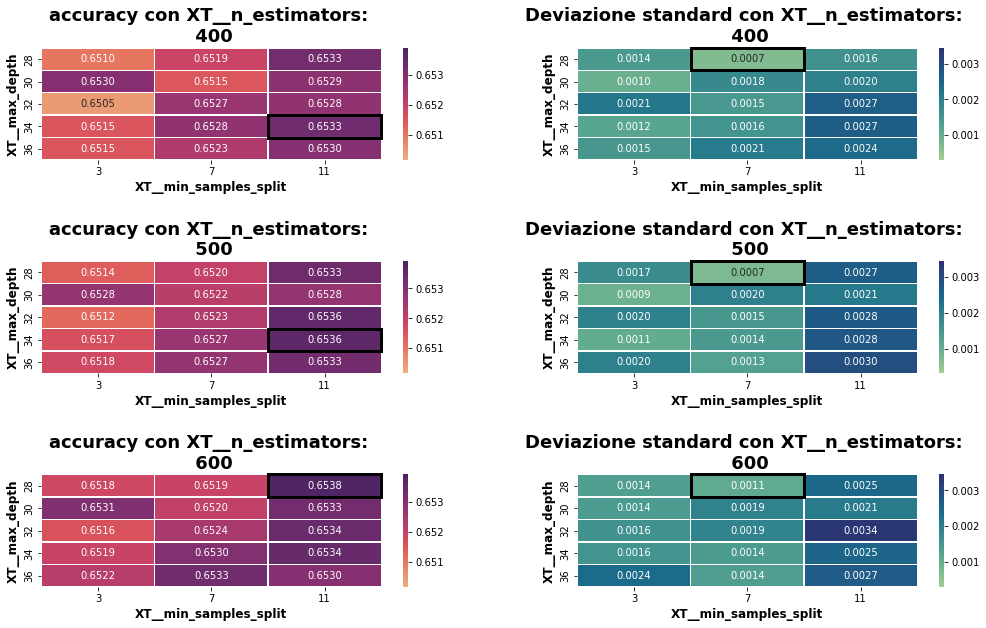

In [ ]:
plot_grid_search_heatmap(XT_table, 'XT__max_depth', 'XT__min_samples_split', 'XT__n_estimators', size=(16, 10), metrica=scoring)

<h3> Miglior Modello <h3>

In [ ]:
XT_pipe_grid_results.best_estimator_['XT']

ExtraTreesClassifier(criterion='entropy', max_depth=28,
                     min_impurity_decrease=3e-07, min_samples_split=11,
                     n_estimators=600, random_state=42)

### Accuratezza sul Test Set

<h3> Alleniamo un nuovo modello con i parametri ottimi e testiamolo <h3>

In [23]:
XT_model_ottimo = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['XT', ExtraTreesClassifier(criterion='entropy', max_depth=30,
                     min_impurity_decrease=3e-07, min_samples_split=3,
                     n_estimators=400, random_state=42)]
    ],
    verbose = True)

XT_model_ottimo.fit(x_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing XT, total=  26.5s


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])),
                ['XT',
                 ExtraTreesClassifier(criterion='entropy', max_depth=30,
            

<h3> Stampiamo l'importanza delle feature <h3>

In [24]:
classes = list(XT_model_ottimo.classes_)
features = list(x.columns)

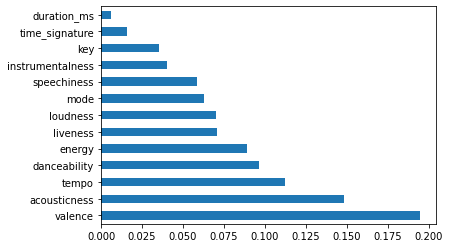

In [25]:
feat_importances = pd.Series(XT_model_ottimo['XT'].feature_importances_, index=features)
feat_importances.nlargest(20).plot(kind='barh')

In [26]:
# calcoliamo le predizione del modello sul test_set
XT_predictions_test = XT_model_ottimo.predict(x_test)
# calcoliamo le predizione del modello sul train_set
XT_predictions_train = XT_model_ottimo.predict(x_train)


# stampiamo un resoconto della predizione
print(classification_report(XT_predictions_test, y_test))
print(f'f1_score_train: {f1_score(y_train,XT_predictions_train,average="weighted")}')
print(f'f1_score_test: {f1_score(y_test,XT_predictions_test,average="weighted")}')

                 precision    recall  f1-score   support

      Dark Trap       0.45      0.50      0.48       622
            Emo       0.67      0.69      0.68       247
         Hiphop       0.39      0.44      0.41       400
            Pop       0.12      0.50      0.19        16
            Rap       0.33      0.53      0.41       171
            RnB       0.35      0.43      0.38       256
     Trap Metal       0.20      0.36      0.26       166
Underground Rap       0.54      0.38      0.44      1257
            dnb       0.98      0.94      0.96       463
      hardstyle       0.94      0.86      0.90       486
      psytrance       0.92      0.90      0.91       457
      techhouse       0.91      0.89      0.90       458
         techno       0.89      0.89      0.89       444
         trance       0.85      0.83      0.84       463
           trap       0.85      0.87      0.86       440

       accuracy                           0.67      6346
      macro avg       0.63   

<h3> Stampiamo la matrice di confusione in forma grafica <h3>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text major ticklabel objects>)

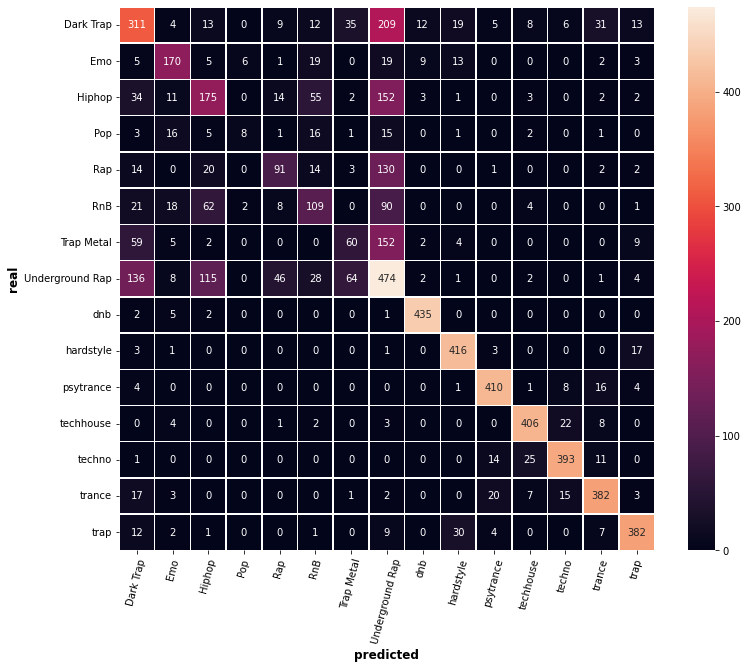

In [27]:
XT_matrix = confusion_matrix(y_test, XT_predictions_test, labels=classes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(XT_matrix, ax=ax, annot=True, fmt='d', linewidths=0.5)
ax.set_xticklabels(classes);
ax.set_yticklabels(classes);
ax.set_xlabel('predicted', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
ax.set_ylabel('real', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)

# CONFRONTO RISULTATI

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Modello', 'F1 Train', 'F1 Test']
table.add_row(['Classification Tree', round(f1_score(y_train,tree_predictions_train,average="micro"), 3), round(f1_score(y_test,tree_predictions_test,average="micro"), 3)])
table.add_row(['Random Forest', round(f1_score(y_train,RDF_predictions_train,average="micro"), 3), round(f1_score(y_test,RDF_predictions_test,average="micro"), 3)])
table.add_row(['KNN', round(f1_score(y_train,knn_predictions_train,average="micro"), 3), round(f1_score(y_test,knn_predictions_test,average="micro"), 3)])
table.add_row(['ExtraTree', round(f1_score(y_train,XT_predictions_train,average="micro"), 3), round(f1_score(y_test,XT_predictions_test,average="micro"), 3)])
print(table)

+---------------------+----------+---------+
|       Modello       | F1 Train | F1 Test |
+---------------------+----------+---------+
|    Random Forest    |  0.809   |  0.688  |
|      ExtraTree      |  0.935   |  0.664  |
| Classification Tree |  0.679   |  0.638  |
|         KNN         |   0.65   |  0.616  |
+---------------------+----------+---------+
